In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time

from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve, learning_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.random_projection import GaussianRandomProjection
from sklearn.metrics import classification_report

from pandas.api.types import is_string_dtype
from pandas.api.types import is_categorical_dtype

In [2]:
def pre_processing(credit):
	# preprocessing - convert data type and dummy coding
	cols = credit.columns
	isCat_Index = list()
	for col in cols:
		if is_string_dtype(credit[col]):
			credit[col] = credit[col].astype('category')
		isCat_Index.append(is_categorical_dtype(credit[col]))
	
	credit_d = pd.get_dummies(credit, columns=list(cols[isCat_Index]))
	print(credit_d.shape)
	return credit_d

In [3]:
SEED = 166

# preprocessing: scaling the data and split dataset
data = pd.read_csv("../credit.csv")
data = pre_processing(data)
predictors = data[data.columns.difference(["default"])]
scaler = MinMaxScaler()
predictors_scaled = scaler.fit_transform(predictors)
target = data[["default"]].values.ravel()

train_X, test_X, train_y, test_y = train_test_split(predictors_scaled, target, train_size=0.8, random_state=SEED, stratify=target)

(1000, 62)


In [6]:
rca = GaussianRandomProjection(n_components=34, random_state=SEED)
rca.fit(train_X)
train_transform = rca.transform(train_X)
test_transform = rca.transform(test_X)

In [7]:
# Grid Search the best parameters
mlp_model = MLPClassifier(random_state=SEED, max_iter=1000)
nodes = [(20), (40), (60), (80), (100), (120), (140), (160),
         (10, 10), (20, 20), (30, 30), (40, 40), (50, 50), (60, 60), (70, 70), (80, 80), (90, 90), (100, 100),
         (30, 10), (50, 30), (50, 10), (70, 50), (70, 30), (70, 10), (90, 70), (90, 50), (90, 30), (90, 10)]
batch_size = [50, 100]

tuned_parameters = {'hidden_layer_sizes': nodes, 'batch_size': batch_size}
clf = GridSearchCV(mlp_model, tuned_parameters, scoring="accuracy", n_jobs=-1, cv=5)
clf.fit(train_transform, train_y)
print(clf.best_score_, clf.best_params_)

0.7300000000000001 {'batch_size': 100, 'hidden_layer_sizes': 140}


In [8]:
mlp_model = MLPClassifier(batch_size=100,hidden_layer_sizes=(140), random_state=SEED, max_iter=1000)

tuned_parameters = {'learning_rate_init': np.arange(0.0005, 0.01, 0.0005),
                    'activation': ["relu", "tanh", "logistic"]}
clf = GridSearchCV(mlp_model, tuned_parameters, scoring="accuracy", n_jobs=-1, cv=5)
clf.fit(train_transform, train_y)
print(clf.best_score_, clf.best_params_)

0.74625 {'activation': 'logistic', 'learning_rate_init': 0.001}


In [10]:
mlp_model = MLPClassifier(batch_size=100,hidden_layer_sizes=(140), activation='logistic', learning_rate_init=0.001, random_state=SEED, max_iter=1000)

t0_clock = time.process_time()
mlp_model.fit(train_transform, train_y)
pred = mlp_model.predict(test_transform)  # Predict with test set
t1_clock = time.process_time()
print("The training time for final selected model is " + str(t1_clock - t0_clock) + " seconds")
print(classification_report(test_y, pred, digits=4))

The training time for final selected model is 7.25 seconds
              precision    recall  f1-score   support

           1     0.7718    0.8214    0.7958       140
           2     0.5098    0.4333    0.4685        60

    accuracy                         0.7050       200
   macro avg     0.6408    0.6274    0.6322       200
weighted avg     0.6932    0.7050    0.6976       200



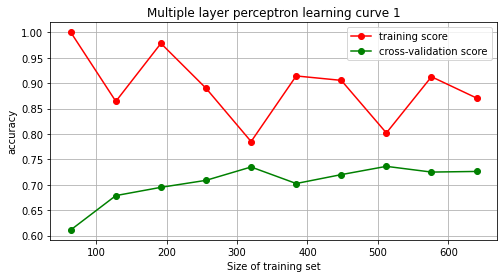

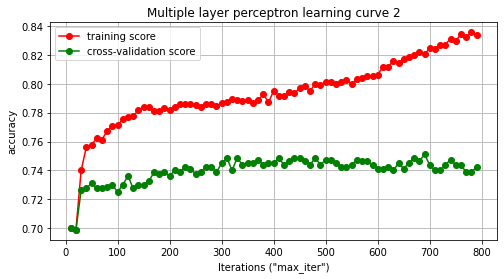

In [14]:
mlp_model = MLPClassifier(batch_size=100,hidden_layer_sizes=(50, 50), activation='logistic', learning_rate_init=0.001, random_state=SEED, max_iter=1000)

# mlp_model.fit(self.train_X, self.train_y) # set verbose=True
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes_abs, train_scores, valid_scores = learning_curve(mlp_model,
                                                                             train_transform, train_y,
                                                                             cv=5, n_jobs=-1,
                                                                             train_sizes=train_sizes,
                                                                             random_state=SEED,
                                                                             scoring="accuracy")
max_iter = np.arange(10, 800, 10)
train_scores2, valid_scores2 = validation_curve \
    (mlp_model, train_transform, train_y, param_name="max_iter", param_range=max_iter, cv=5,
     n_jobs=-1, scoring="accuracy")

plt.figure(figsize=(8, 4))
# plt.subplot(211)
plt.plot(train_sizes_abs, train_scores.mean(axis=1), 'o-', color='r', label="training score")
plt.plot(train_sizes_abs, valid_scores.mean(axis=1), 'o-', color='g', label="cross-validation score")
plt.xlabel('Size of training set')
plt.ylabel('accuracy')
plt.legend(loc="best")
plt.title("Multiple layer perceptron learning curve 1")
plt.grid()
plt.savefig(r'C:\Users\Yiwei Zhang\Desktop\plots\rca_nn1.png', dpi=300)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(max_iter, train_scores2.mean(axis=1), 'o-', color='r', label="training score")
plt.plot(max_iter, valid_scores2.mean(axis=1), 'o-', color='g', label="cross-validation score")
plt.xlabel('Iterations ("max_iter")')
plt.ylabel('accuracy')
plt.legend(loc="best")
plt.title("Multiple layer perceptron learning curve 2")
plt.grid()
plt.savefig(r'C:\Users\Yiwei Zhang\Desktop\plots\rca_nn2.png', dpi=300)
plt.show()